In [1]:
#@title Importing Packages
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

#save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# load numpy array from npz file
from numpy import load

from tqdm import tqdm as tqdm

In [2]:
#@title Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Path**

In [4]:
absolute_path = os.path.abspath('')

# relative_path = "/drive/MyDrive/Research/DLGN_Fashion_MNIST/Saved_models_latest/" #for running in colab
relative_path = "/Saved_models/" #for local running

file_path = absolute_path+relative_path


In [5]:
#@title Fashion MNIST

In [6]:
#@title Parameters

#DLGN(DLGN Model with only 3 linear layer containing 10,10,10 hidden nodes)
#DeepnonLinearModel(Model with only 3 non linear layer containing 10,10,10 hidden nodes)

#Replace any of the following in model_name to run that mode
#DLGN/DeepnonLinearModel

# file_path = "/content/drive/MyDrive/Research/DLGN_Fashion_MNIST/Saved_models_latest/"
# file_name1 = "test_DLGN.npz"
# error_file = "error_test_DLGN.npz"
# file_name1 = "ReLU_no_patch_no_extra_data_train_test_5_per_data_lr_.0001_epoch_1k_seed_365.npz"
# error_file = "Error_ReLU_no_patch_no_extra_data_train_test_5_per_data_lr_.0001_epoch_1k_seed_365.npz"

# file_name1 = "ReLU_no_patch_no_extra_data_train_test_5_per_data_lr_.001_epoch_2k_seed_365.npz"
# error_file = "Error_ReLU_no_patch_no_extra_data_train_test_5_per_data_lr_.001_epoch_2k_seed_365.npz"

# file_name1="ReLU_no_patch_no_extra_data_lr_.001_epoch_1k_seed_365.npz"
# error_file = "Error_ReLU_no_patch_no_extra_data_train_test_lr_.001_epoch_1k_seed_365.npz"


num_hidden_layers=3
input_dim=784
output_dim=10
num_hidden_nodes=[10,10,10]
modep='pwc'
model_name = 'DLGN' #DLGN/DeepnonLinearModel
batch_size = 64
beta = 20
epochs = 1000
learning_rate = 0.001
optimizer_name ='SGD'
num_of_classes = 10 #10 -> using all 10 classes of FMNIST
n_corr_data = 0/100 #fraction of the data that is made corrupted
corrupted_train = False #True - fraction of the data is corrupted, False- expt on real data w.o corruption
corrupted_test = False
use_x_percent_data = 100 #default:100. Percentage of the data used in training, if 100 use the full data as it is
extra_data_train = False #True - Adding additional real data corresponding to the corrupted data, False- no addition
extra_data_test = False
simplified_patch_train = False #True - white patch and rest full black on train corrupted portion of the data
simplified_patch_test = False #white patch and rest full black on test corrupted portion of the data
model_training = False #True --> to train a new model else False
model_inference = False #True --> to generate error files(error vs epoch plots) else false
seed = 365

In [7]:
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [8]:
set_npseed(seed)

**Load Dataset**

In [9]:
#image transform and normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))])


#defining train and test sets.
trainset = torchvision.datasets.FashionMNIST('data',
                                             download=True,
                                             train=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('data',
                                            download=True,
                                            train=False,
                                            transform=transform)


**Important**

In [10]:
# https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader
# https://pytorch.org/docs/stable/data.html#module-torch.utils.data
# https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html#totensor
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# trainset.data[1][:4,:4]=0 can be used to access and modify the data from actual dataset downloaded in __init__

In [11]:
# trainset[1][0][0][:4,:4] this is the data after transform that is used in training after taking index by index using __get_item()__ function and it is non-editable

In [12]:
#@title 100% data + n_corr_data% corrupted data
#trainset
if extra_data_train:
  extra_train_data = torch.zeros(int(trainset.data.shape[0]*n_corr_data),trainset.data.shape[1],trainset.data.shape[2],dtype=torch.uint8)
  extra_train_target = torch.zeros(int(trainset.targets.shape[0]*n_corr_data),dtype=torch.int64)

  #testset
if extra_data_test:
  extra_test_data = torch.zeros(int(testset.data.shape[0]*n_corr_data),testset.data.shape[1],testset.data.shape[2],dtype=torch.uint8)
  extra_test_target = torch.zeros(int(testset.targets.shape[0]*n_corr_data),dtype=torch.int64)

In [13]:
#@title **Left 4x4 n_corr_data% data 5 classes, right 4x4 n_corr_data% data for 5 classes**
if num_of_classes==10:
  if corrupted_train:
    #train_set
    count_corrupt = 0
    count = len(trainset)//10
    count_class= [0,0,0,0,0,0,0,0,0,0]
    for i in range(len(trainset)):
      data_class = trainset.targets[i].item()
      if((data_class<5)&(count_class[data_class]<count*n_corr_data)):
        if extra_data_train:
          extra_train_data[count_corrupt]=trainset.data[i].detach().clone()
          extra_train_target[count_corrupt]=trainset.targets[i].detach().clone()
          
          # print(extra_train_target[count_corrupt])
          count_corrupt=count_corrupt+1
        trainset.data[i][0+6*data_class:4+6*data_class,0:4]=255
        if simplified_patch_train:
          rest_black = torch.zeros(trainset.data[i].shape)
          rest_black[0+6*data_class:4+6*data_class,0:4]=255
          trainset.data[i] = rest_black
        trainset.targets[i]=(trainset.targets[i]+10) #added to differentiate the corrupted data from the uncorrupted data, corrupted data will have target value as target value+10
        count_class[data_class]+=1
      if((data_class>=5)&(count_class[data_class]<count*n_corr_data)):
        if extra_data_train:
          extra_train_data[count_corrupt]=trainset.data[i].detach().clone()
          extra_train_target[count_corrupt]=trainset.targets[i].detach().clone()
          count_corrupt=count_corrupt+1
        trainset.data[i][0+6*(data_class-5):4+6*(data_class-5),-4:]=255
        if simplified_patch_train:
          rest_black = torch.zeros(trainset.data[i].shape)
          rest_black[0+6*(data_class-5):4+6*(data_class-5),-4:]=255
          trainset.data[i] = rest_black
        trainset.targets[i]=(trainset.targets[i]+10)
        count_class[data_class]+=1

    #test_set
  if corrupted_test:
    count_corrupt_test = 0
    count_test = len(testset)//10
    count_class_test= [0,0,0,0,0,0,0,0,0,0]
    for i in range(len(testset)):
      data_class_test = testset.targets[i].item()
      if((data_class_test<5)&(count_class_test[data_class_test]<count_test*n_corr_data)):
        if extra_data_test:
          extra_test_data[count_corrupt_test]=testset.data[i].detach().clone()
          extra_test_target[count_corrupt_test]=testset.targets[i].detach().clone()
          count_corrupt_test=count_corrupt_test+1
        testset.data[i][0+6*data_class_test:4+6*data_class_test,0:4]=255
        if simplified_patch_test:
          rest_black = torch.zeros(testset.data[i].shape)
          rest_black[0+6*data_class_test:4+6*data_class_test,0:4]=255
          testset.data[i] = rest_black
        testset.targets[i]=(testset.targets[i]+10)
        count_class_test[data_class_test]+=1
      if((data_class_test>=5)&(count_class_test[data_class_test]<count_test*n_corr_data)):
        if extra_data_test:
          extra_test_data[count_corrupt_test]=testset.data[i].detach().clone()
          extra_test_target[count_corrupt_test]=testset.targets[i].detach().clone()
          count_corrupt_test=count_corrupt_test+1
        testset.data[i][0+6*(data_class_test-5):4+6*(data_class_test-5),-4:]=255
        if simplified_patch_test:
          rest_black = torch.zeros(testset.data[i].shape)
          rest_black[0+6*(data_class_test-5):4+6*(data_class_test-5),-4:]=255
          testset.data[i] = rest_black
        testset.targets[i]=(testset.targets[i]+10)
        count_class_test[data_class_test]+=1

In [14]:
#@title Custom Dataset
class CustomDataset:
  def __init__(self,data,targets):
    self.data = data
    self.targets = targets
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,idx):
    current_sample = self.data[idx,:,:]
    current_target = self.targets[idx]
    return current_sample,current_target

In [15]:
#Creating x% training dataset
if use_x_percent_data!=100:
  data_size = int(trainset.targets.shape[0]*(use_x_percent_data/100))
  train_data_x_per = torch.zeros(data_size,trainset.data.shape[1],trainset.data.shape[2],dtype=torch.uint8)
  train_target_x_per = torch.zeros(data_size,dtype=torch.int64)
  train_data_x_per[0:data_size]=trainset.data[0:data_size].detach().clone()
  train_target_x_per[0:data_size]=trainset.targets[0:data_size].detach().clone()
  train_dataset = CustomDataset(data=train_data_x_per, targets= train_target_x_per)
  trainset.data=train_dataset.data
  trainset.targets = train_dataset.targets


In [16]:
if extra_data_train:
  train_dataset_extra = CustomDataset(data=extra_train_data, targets= extra_train_target)
  trainset.data = torch.vstack([trainset.data,train_dataset_extra.data])
  trainset.targets = torch.cat([trainset.targets,train_dataset_extra.targets])

if extra_data_test:
  test_dataset_extra = CustomDataset(data=extra_test_data, targets= extra_test_target)
  testset.data = torch.vstack([testset.data,test_dataset_extra.data])
  testset.targets = torch.cat([testset.targets,test_dataset_extra.targets])

In [17]:
#Creating dataloaders for both training and testing
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,
                                        shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = batch_size,
                                      shuffle=False)


In [18]:
# #constant for different classes in the dataset
# classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat'
#       ,'Sandal','Shirt','Sneaker','Bag','Ankle Boot')

#function to show an image
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img=img.mean(dim=0)
  img = img/2 + 0.5 #unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [19]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

**Visualizing Training Examples**

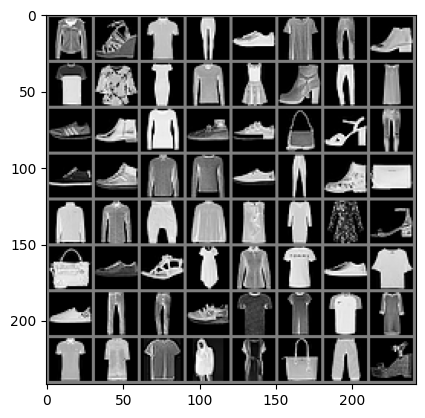

In [20]:
dataiter = iter(trainloader)
images,labels = next(dataiter)
matplotlib_imshow(torchvision.utils.make_grid(images))

In [21]:
#@title **DLGN_FC**
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=784, output_dim=10, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False,device=device).to(device))
    else:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].cpu().weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].cpu().bias.detach().numpy()))
        self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].cpu().weight.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    x=x.view(x.shape[0],-1)
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape).to(device)]
    else:
      values=[x]
    for i in range(self.num_hidden_layers):
      gate_scores.append(self.gating_layers[i].to(device)(gate_scores[-1].to(device)).to(device))
      curr_gate_on_off = torch.sigmoid(beta*gate_scores[-1].to(device)).to(device)
      values.append(self.value_layers[i].to(device)(values[-1].to(device)).to(device)*curr_gate_on_off.to(device))
    values.append(self.value_layers[self.num_hidden_layers].to(device)(values[-1].to(device)).to(device))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores

Using cpu device


**DNN Architecture**

In [22]:
#@title **DNL_FC**
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DNL_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=784, output_dim=10, num_hidden_nodes=[]):
    super(DNL_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
    else:
      self.gating_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].cpu().weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].cpu().bias.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    x=x.view(x.shape[0],-1)
    gate_scores=[x]
    
    for i in range(self.num_hidden_layers):
      gate_scores.append(F.relu(self.gating_layers[i].to(device)(gate_scores[-1].to(device)).to(device)))
    gate_scores.append(F.log_softmax(self.gating_layers[self.num_hidden_layers].to(device)(gate_scores[-1].to(device)).to(device),dim=1))
    return gate_scores

Using cpu device


In [23]:
#@title **Check perfect sq**
def perfectSq(N) :
	sq_root = round(N**(1/2));
	if sq_root * sq_root == N :
		return True;
	else :
		return False;

In [24]:
#@title **Train model**
def train_model(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,batch_size,mode,num_epoch):
  set_torchseed(seed)
  Model_obj = None
  
  if model_name == 'DLGN':
    Model_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)     
    
 
  if model_name == 'DeepnonLinearModel':
    Model_obj = DNL_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes)    
  
  Model_obj=Model_obj.to(device) 

  
  Model_params = []
  Model_params += [item.weight for item in Model_obj.gating_layers]
  Model_params += [item.bias for item in Model_obj.gating_layers]
  if model_name == 'DLGN':
    Model_params += [item.weight for item in Model_obj.value_layers]

  
 
  if optimizer_name == 'SGD':
    optimizer = optim.SGD(Model_params, lr=learning_rate)
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(Model_params, lr=learning_rate)

  criterion = nn.NLLLoss()
 
  losses=[]
  Model_obj_store = []
  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    if perfectSq(epoch):
      if model_name == 'DLGN':
        Model_obj_store.append(DLGN_FC(to_copy=Model_obj))
      if model_name == 'DeepnonLinearModel':
        Model_obj_store.append(DNL_FC(to_copy=Model_obj))
    
    for images,labels in trainloader:
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      
      if model_name == 'DLGN':
        values,gate_scores = Model_obj(images)
        loss = criterion(F.log_softmax(values[-1],dim=1),labels%10)
      if model_name == 'DeepnonLinearModel':
        gate_scores = Model_obj(images)
        loss = criterion(gate_scores[-1],labels%10)
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item()    
    losses.append(running_loss/len(trainloader))

  return losses, Model_obj_store

In [25]:
if model_training:
  losses, model_store = train_model(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,batch_size,
                  modep,epochs)

  # save to npy file
  file_name=file_path+file_name1
  savez_compressed(file_name, losses, model_store)

In [26]:
#@title Inference Loop
def eval_fun(corrupted,data_loader,model):
  total = 0
  correct = 0

  if corrupted:
    total_corrupted = 0
    correct_corrupted = 0
    total_real = 0
    correct_real = 0

  #evaluation
  model.eval()
  with torch.no_grad():
    for images,labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      if model_name == 'DLGN':
        values,gate_scores = model(images)
        max_index = torch.argmax(F.log_softmax(values[-1],dim=1),dim=1)
      if model_name == 'DeepnonLinearModel':
        gate_scores = model(images)
        max_index = torch.argmax(gate_scores[-1],dim=1)
      total+=labels.numel()
      correct+=sum(max_index==(labels%10)).item()

    #For separate corrupted and real train images
      if corrupted:
        idx_corr=labels>9
        total_corrupted += idx_corr.sum().item()
        correct_corrupted+=(sum((labels[idx_corr]%10)==max_index[idx_corr]))
        idx_real=labels<=9
        total_real+=idx_real.sum().item()
        correct_real+=sum((labels[idx_real]%10)==max_index[idx_real])
        # for lb in range(len(labels)):
        #   if(labels[lb]>9):
        #     total_corrupted+=1
        #     correct_corrupted+=((labels[lb]%10)==max_index[lb]).item()
        #   else:
        #     total_real+=1
        #     correct_real+=((labels[lb]%10)==max_index[lb]).item()
    loss_z_o = (total-correct)/(total)
    if corrupted:
      loss_z_o_corrupted = (total_corrupted-correct_corrupted)/(total_corrupted)
      loss_z_o_real = (total_real-correct_real)/(total_real)
      # print(total,total_corrupted,total_real)
      # print(correct,correct_corrupted,correct_real)
    acc=(correct/total*100)
  if corrupted:
    return acc,loss_z_o,loss_z_o_corrupted,loss_z_o_real
  else:
    return acc,loss_z_o


In [27]:
if model_inference:
  max_epoch=0
  max_acc=0
  epoch_count = []
  train_error = []
  test_error = []

  if corrupted_train:
    train_corrupted_error = []
    train_real_error = []
  if corrupted_test:
    test_corrupted_error = []
    test_real_error = []


  file_name_load  = file_path + file_name1
  # load numpy array from npz file
  # load dict of arrays
  dict_data = load(file_name_load,allow_pickle=True)
  losses=dict_data['arr_0']
  model_store=dict_data['arr_1']
  
  for index in range(len(model_store)):
    model=model_store[index]
    #Calculating the error for training data
    if corrupted_train:
      acc,loss_z_o_train,loss_z_o_corrupted_train,loss_z_o_real_train = eval_fun(corrupted_train,trainloader,model)
    else:
      acc,loss_z_o_train = eval_fun(corrupted_train,trainloader,model)
    train_error.append(loss_z_o_train)
    if corrupted_train:
      train_corrupted_error.append(loss_z_o_corrupted_train)
      train_real_error.append(loss_z_o_real_train)

    # print(f"Epoch[{e}/{epochs}]: Training loss:{running_loss/1000}",end=" ")
    print(f"Epoch[{index*index}/{epochs}]: Training zero_one loss:{loss_z_o_train}")
    # print(f"Epoch[{e}/{epochs}]: Training zero_one corrupted image loss:{loss_z_o_corrupted_train}",end=" ")
    # print(f"Epoch[{e}/{epochs}]: Training zero_one real image loss:{loss_z_o_real_train}",end=" ")


    #Calculating the error for test data
    if corrupted_test:
      acc,loss_z_o_test,loss_z_o_corrupted_test,loss_z_o_real_test = eval_fun(corrupted_test,testloader,model)
    else:
      acc,loss_z_o_test = eval_fun(corrupted_test,testloader,model)
    test_error.append(loss_z_o_test)
    if corrupted_test:
      test_corrupted_error.append(loss_z_o_corrupted_test)
      test_real_error.append(loss_z_o_real_test)

    # print(f"Test Accuracy {acc:.2f}",end=" ")
    print(f"Test Error {loss_z_o_test}")
    # print(f"Test Error corrupted images {loss_z_o_corrupted_test}",end=" ")
    # print(f"Test Error real images {loss_z_o_real_test}")

    epoch_count.append(index)

    if(acc>max_acc):
      max_acc = acc
      max_epoch = index

  file_name_error=file_path+error_file
  if(corrupted_train and corrupted_test):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error)
  elif(corrupted_train):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error)
  elif(corrupted_test):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error)
  else:
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error)



**Nodes Visualization**

In [130]:
DLGN_50_full_black_patch="DLGN_50_full_black_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
DLGN_50_white_patch="DLGN_50_white_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
DLGN_95_full_black_patch="DLGN_95_full_black_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
DLGN_95_white_patch="DLGN_95_white_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
DLGN_no_patch="DLGN_no_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
DLGN_no_patch_5_percent="DLGN_no_patch_no_extra_data_train_test_5_per_data_lr_.0001_epoch_1k_seed_365.npz"

ReLU_50_full_black_patch="ReLU_50_full_black_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
ReLU_50_white_patch="ReLU_50_white_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
ReLU_95_full_black="ReLU_95_full_black_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
ReLU_95_white_patch="ReLU_95_white_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
ReLU_no_patch="ReLU_no_patch_no_extra_data_lr_.0001_epoch_1k_seed_365.npz"
ReLU_no_patch_5_percent="ReLU_no_patch_no_extra_data_train_test_5_per_data_lr_.0001_epoch_1k_seed_365.npz"

In [131]:
file_name_load=file_path+DLGN_95_white_patch
dict_data = load(file_name_load,allow_pickle=True)
losses=dict_data['arr_0']
model_store=dict_data['arr_1']

**Generating Query and Query complement**

In [132]:
Query_img=torch.zeros(1,trainset.data.shape[1],trainset.data.shape[2],dtype=torch.float32)-1
Query_img_comp=torch.zeros(1,trainset.data.shape[1],trainset.data.shape[2],dtype=torch.float32)+1
Query_img[0][:,0:4]=1
Query_img[0][:,-4:]=1
Query_img_comp[0][:,0:4]=-1
Query_img_comp[0][:,-4:]=-1

In [133]:
'''
trainset.data.shape #torch.Size([60000, 28, 28])
images.shape #torch.Size([64, 1, 28, 28])
images_test = images.view(images.shape[0],-1)
images_test.shape #torch.Size([64, 784])
Query_img_flatten.shape #torch.Size([1, 784])
Query_img_comp_flatten.shape #torch.Size([1, 784])
'''

'\ntrainset.data.shape #torch.Size([60000, 28, 28])\nimages.shape #torch.Size([64, 1, 28, 28])\nimages_test = images.view(images.shape[0],-1)\nimages_test.shape #torch.Size([64, 784])\nQuery_img_flatten.shape #torch.Size([1, 784])\nQuery_img_comp_flatten.shape #torch.Size([1, 784])\n'

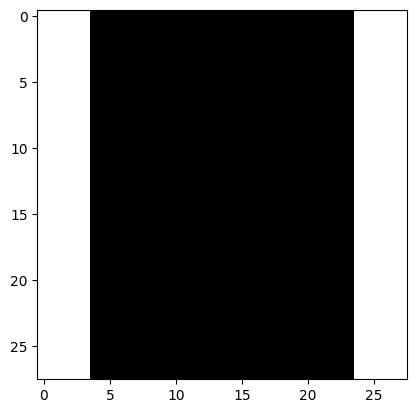

In [134]:
matplotlib_imshow(torchvision.utils.make_grid(Query_img))

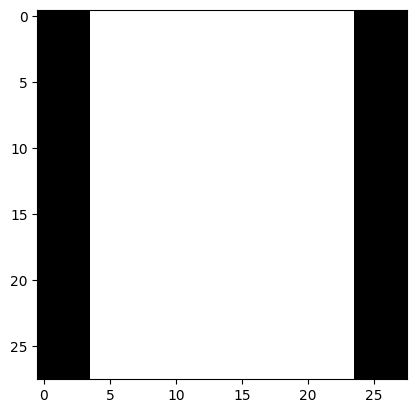

In [135]:
matplotlib_imshow(torchvision.utils.make_grid(Query_img_comp))

In [136]:
Query_img_flatten=Query_img.view(Query_img.shape[0],-1)
Query_img_comp_flatten=Query_img_comp.view(Query_img_comp.shape[0],-1)

In [137]:
Query_img_flatten.shape

torch.Size([1, 784])

In [138]:
Query_img_comp_flatten.shape

torch.Size([1, 784])

In [123]:
num_models_to_store = int(round(len(model_store)/3))+1

In [140]:
node_activity_score=np.zeros((num_models_to_store,num_hidden_layers,num_hidden_nodes[0]))
index=0
for epoch_index in range(len(model_store)):
  if(epoch_index%3==0 or epoch_index==len(model_store)-1):
    effective_weights, effective_biases = model_store[epoch_index].return_gating_functions()
    for layer_num in range(num_hidden_layers):
      for node_num in range(num_hidden_nodes[layer_num]):
        weight = effective_weights[layer_num][node_num].data.numpy()
        EW_Q = Query_img_flatten@weight.T
        EW_Q_comp = Query_img_comp_flatten@weight.T
        node_activity_score[index][layer_num][node_num]=EW_Q-EW_Q_comp
    index=index+1

In [141]:
node_activity_score_layer0=node_activity_score[:,0,:]
node_activity_score_layer1=node_activity_score[:,1,:]
node_activity_score_layer2=node_activity_score[:,2,:]

In [144]:
epoch_count_store = [0, 9,36,81, 144,225,324, 441,576,729, 900,961]

In [142]:
node_activity_score_layer0_table = pd.DataFrame(data = node_activity_score_layer0, 
                        index = ["E_0", "E_9","E_36","E_81", "E_144","E_225","E_324", "E_441","E_576","E_729", "E_900","E_961"],
                        columns = ["Node_0","Node_1", "Node_2","Node_3","Node_4", "Node_5","Node_6","Node_7", "Node_8","Node_9"])
node_activity_score_layer0_table.style.set_caption("Layer 0")


,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9
E_0,-0.675664,0.209983,1.799035,0.163145,2.283648,-1.656336,-0.879778,0.166632,-0.543932,0.105423
E_9,-1.459752,-1.487190,2.052450,-0.894939,1.114167,0.430006,-1.517866,0.222006,-2.014695,-0.244824
E_36,-0.306769,-1.302780,-0.947000,-2.135075,-0.068997,-0.040646,-1.077948,-0.521971,-3.669501,-1.526126
E_81,0.097965,-1.056707,-1.230699,-2.146878,-0.248753,-0.076586,-1.446493,-0.465138,-3.941835,-0.881761
E_144,0.463767,-1.003904,-1.437746,-2.101685,-0.550472,-0.114277,-1.879590,-0.351077,-4.110276,-0.259123
E_225,0.756463,-0.928479,-1.471123,-2.114178,-0.666345,-0.181484,-2.138446,-0.347914,-4.203029,0.126025
E_324,0.857159,-0.865871,-1.438276,-2.022291,-0.710603,-0.202858,-2.332289,-0.424796,-4.378956,0.361572
E_441,0.866515,-0.755854,-1.289140,-1.906129,-0.726897,-0.120678,-2.437189,-0.558009,-4.471154,0.500345
E_576,0.857361,-0.684948,-1.247371,-1.717679,-0.756561,-0.091159,-2.461363,-0.681648,-4.528091,0.613071
E_729,0.858983,-0.645030,-1.259876,-1.487331,-0.710295,-0.056799,-2.409645,-0.810245,-4.594248,0.688290


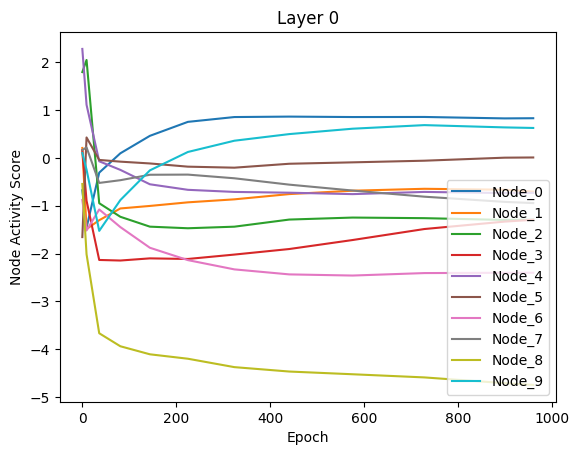

In [145]:
plt.figure()
for node_num in range(num_hidden_nodes[0]):
  plt.plot(epoch_count_store,node_activity_score_layer0.T[node_num],label="Node_"+str(node_num))
plt.xlabel('Epoch')
plt.ylabel('Node Activity Score')
plt.title('Layer 0')
plt.legend()
plt.show()

In [147]:
node_activity_score_layer1_table = pd.DataFrame(data = node_activity_score_layer1, 
                        index = ["E_0", "E_9","E_36","E_81", "E_144","E_225","E_324", "E_441","E_576","E_729", "E_900","E_961"],
                        columns = ["Node_0","Node_1", "Node_2","Node_3","Node_4", "Node_5","Node_6","Node_7", "Node_8","Node_9"])
node_activity_score_layer1_table.style.set_caption("Layer 1")

,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9
E_0,0.872430,0.191430,-0.340464,1.431685,-0.438016,-0.388413,0.177583,-0.730982,-0.662187,-1.797298
E_9,0.383445,-0.374750,-0.436324,0.944756,0.373755,-0.770574,0.277033,0.646312,-1.352788,-1.912701
E_36,0.048777,0.131896,-0.567117,0.871206,0.851883,0.090894,0.201069,0.561163,-0.751090,-0.604206
E_81,0.028609,0.093432,-0.599753,0.697368,0.848742,0.108451,0.289627,0.404392,-0.599991,-0.586128
E_144,-0.006691,-0.039254,-0.589789,0.418024,0.863539,0.148053,0.359583,0.279222,-0.472268,-0.646154
E_225,0.009815,-0.138097,-0.623672,0.293497,0.789459,0.135447,0.388592,0.237369,-0.394272,-0.686644
E_324,0.058659,-0.196207,-0.649515,0.249033,0.807884,0.088675,0.381958,0.201492,-0.382237,-0.794369
E_441,0.140562,-0.245291,-0.669328,0.248328,0.838037,-0.011402,0.326331,0.234912,-0.398559,-0.863551
E_576,0.192977,-0.277401,-0.649327,0.218622,0.879274,-0.067441,0.297945,0.209256,-0.395738,-0.911103
E_729,0.198038,-0.301388,-0.615219,0.201057,0.911856,-0.119884,0.285431,0.154243,-0.389681,-0.947452


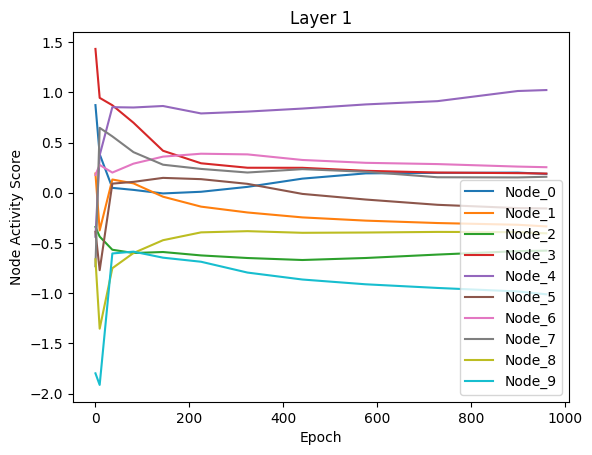

In [148]:
plt.figure()
for node_num in range(num_hidden_nodes[0]):
  plt.plot(epoch_count_store,node_activity_score_layer1.T[node_num],label="Node_"+str(node_num))
plt.xlabel('Epoch')
plt.ylabel('Node Activity Score')
plt.title('Layer 1')
plt.legend()
plt.show()

In [149]:
node_activity_score_layer2_table = pd.DataFrame(data = node_activity_score_layer2, 
                        index = ["E_0", "E_9","E_36","E_81", "E_144","E_225","E_324", "E_441","E_576","E_729", "E_900","E_961"],
                        columns = ["Node_0","Node_1", "Node_2","Node_3","Node_4", "Node_5","Node_6","Node_7", "Node_8","Node_9"])
node_activity_score_layer2_table.style.set_caption("Layer 2")

,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9
E_0,0.437707,-0.488932,0.181441,0.205648,-0.644650,-0.316543,-0.360954,-0.081122,1.148765,-0.895731
E_9,0.791818,-0.417392,0.366219,-0.030292,-0.510427,-0.525094,-0.874671,0.341778,1.357747,-0.703910
E_36,0.107746,-0.317730,0.331762,0.166913,-0.097538,-0.213491,-0.603002,0.330380,0.584649,-0.278052
E_81,0.131561,-0.240200,0.340548,0.114535,-0.139839,-0.197795,-0.483461,0.415486,0.485110,-0.257108
E_144,0.219034,-0.151066,0.348556,0.068230,-0.173311,-0.186206,-0.381346,0.512569,0.398893,-0.237453
E_225,0.248636,-0.133780,0.335107,0.006682,-0.219532,-0.201731,-0.333561,0.538471,0.394958,-0.265154
E_324,0.304485,-0.113777,0.368047,-0.006166,-0.241777,-0.215611,-0.328049,0.588088,0.426861,-0.301961
E_441,0.340604,-0.104804,0.391862,-0.018338,-0.233529,-0.231606,-0.351870,0.620833,0.480006,-0.332271
E_576,0.387829,-0.069098,0.415652,-0.009964,-0.216530,-0.230613,-0.346117,0.656449,0.487378,-0.342189
E_729,0.427370,-0.019457,0.441763,0.008690,-0.219981,-0.229053,-0.334147,0.686522,0.474417,-0.336936


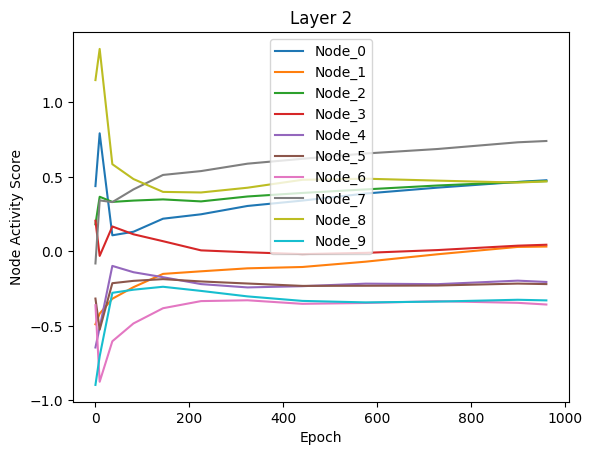

In [150]:
plt.figure()
for node_num in range(num_hidden_nodes[0]):
  plt.plot(epoch_count_store,node_activity_score_layer2.T[node_num],label="Node_"+str(node_num))
plt.xlabel('Epoch')
plt.ylabel('Node Activity Score')
plt.title('Layer 2')
plt.legend()
plt.show()

**RESULTS**

**Saved error files**

In [47]:
##Saved_models_latest

error_dlgn_no_patch_5_perc = "Error_DLGN_no_patch_no_extra_data_train_test_5_per_data_lr_.0001_epoch_1k_seed_365.npz"
error_dlgn_no_patch = "Error_DLGN_no_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"

error_dlgn_50_white_patch = "Error_DLGN_50_white_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_dlgn_50_full_black = "Error_DLGN_50_full_black_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_dlgn_95_white_patch = "Error_DLGN_95_white_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_dlgn_95_full_black = "Error_DLGN_95_full_black_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"

error_relu_no_patch = "Error_ReLU_no_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"

error_relu_50_white_patch = "Error_ReLU_50_white_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_relu_50_full_black = "Error_ReLU_50_full_black_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_relu_95_white_patch = "Error_ReLU_95_white_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"
error_relu_95_full_black = "Error_ReLU_95_full_black_patch_no_extra_data_train_test_lr_.0001_epoch_1k_seed_365.npz"

In [151]:
#@title load error file
def load_error_file(error_file):
  file_name_load_error = file_path+error_file
  dict_data_error = load(file_name_load_error,allow_pickle=True)

  if(corrupted_train and corrupted_test):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    train_corrupted_error=dict_data_error['arr_5']
    train_real_error=dict_data_error['arr_6']
    test_corrupted_error=dict_data_error['arr_7']
    test_real_error=dict_data_error['arr_8']
    return max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error

  elif(corrupted_train):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    train_corrupted_error=dict_data_error['arr_5']
    train_real_error=dict_data_error['arr_6']
    return max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error

  elif(corrupted_test):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    test_corrupted_error=dict_data_error['arr_5']
    test_real_error=dict_data_error['arr_6']
    return max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error

  else:
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    return max_epoch,max_acc,epoch_count,train_error,test_error



In [152]:
corrupted_train = False 
corrupted_test = False

In [153]:
max_epoch_no_patch_5_perc,max_acc_no_patch_5_perc,epoch_count_no_patch_5_perc,train_error_no_patch_5_perc,test_error_no_patch_5_perc=load_error_file(error_dlgn_no_patch_5_perc)

In [154]:
max_epoch_no_patch,max_acc_no_patch,epoch_count_no_patch,train_error_no_patch,test_error_no_patch=load_error_file(error_dlgn_no_patch)

**Error File update**

In [155]:
#update the error file with error_files from Saved error files tab
corrupted_train = True 
corrupted_test = True  
error_file = error_dlgn_95_white_patch  

In [156]:
if(corrupted_train and corrupted_test):
  max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error=load_error_file(error_file)

elif(corrupted_train):
  max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error=load_error_file(error_file)

elif(corrupted_test):
  max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error=load_error_file(error_file)

else:
  max_epoch,max_acc,epoch_count,train_error,test_error=load_error_file(error_file)



In [157]:
print(max_acc)
print(max_epoch)

98.89
841


**Plot Train error curves**

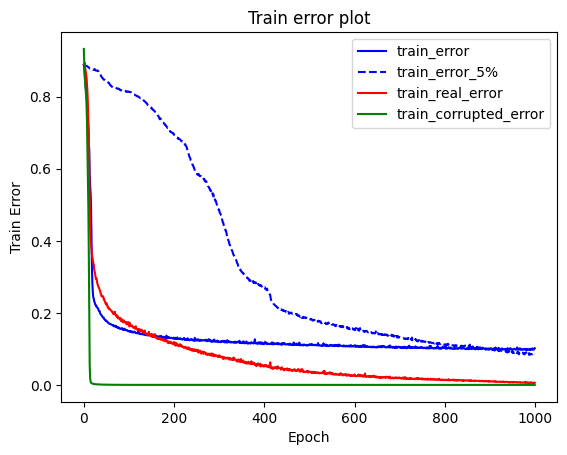

In [158]:
plt.figure()
plt.plot(train_error_no_patch[:],'b',label="train_error")
plt.plot(train_error_no_patch_5_perc[:],'b--',label="train_error_5%")

if corrupted_train:
  plt.plot(train_real_error[:],'r',label="train_real_error")
  plt.plot(train_corrupted_error[:],'g',label="train_corrupted_error")
plt.xlabel('Epoch')
plt.ylabel('Train Error')
plt.title('Train error plot')
plt.legend()
plt.show()

**Plot Test error curves**

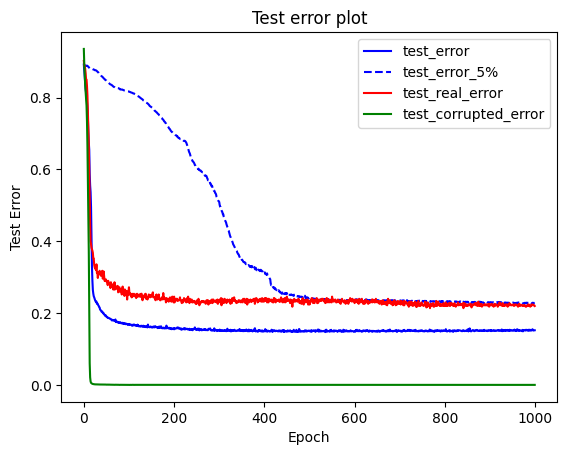

In [159]:
plt.figure()
plt.plot(test_error_no_patch[:],'b',label="test_error")
plt.plot(test_error_no_patch_5_perc[:],'b--',label="test_error_5%")

if corrupted_test:
  plt.plot(test_real_error[:],'r',label="test_real_error")
  plt.plot(test_corrupted_error[:],'g',label="test_corrupted_error")
else:
  plt.plot(test_error[:],label="test_real_error")
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title('Test error plot')
plt.legend()
plt.show()